# Finding best model with Gaussian Process Regression (GPR)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib notebook

In [3]:
# import own modules
import run_gpr
from gpr_alg import plot_data

# import external modules
import warnings
import pandas as pd
import numpy as np
import sklearn.gaussian_process as gp

## Find best model

We start be performing a grid search to find the best model for the given dataset. The ouput is saved in a file.

In [4]:
# Load statistics from model fitting with different kernels
store = pd.HDFStore('grid_search_stats_2D_100_iterations.h5')
model_stats = store['df']

model_stats

,kernel,stats,pred_mean,pred_cov
0,RBF: {'length_scale': 9.999999999999997e-06},0.250731,"[0.0, 0.0, 1.4164325136245364, 2.2725576763579...","[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
6,RationalQuadratic: {'length_scale': 1.00006289...,0.250731,"[7.55590629824256e-08, 2.5353298829773087e-07,...","[[0.999999999999992, 7.278481404464539e-08, 5...."
7,RationalQuadratic: {'length_scale': 0.15766103...,0.001012,"[-0.37765718750767974, 0.5169779829632262, 1.4...","[[0.00014372708454701844, 3.996762962366063e-0..."
8,RationalQuadratic: {'length_scale': 0.16746311...,0.001019,"[-0.37275601613600884, 0.5182720963775864, 1.4...","[[0.00015693048402221077, 4.3401893531913593e-..."
9,RationalQuadratic: {'length_scale': 0.16746636...,0.001019,"[-0.3727559421706701, 0.5182721794230929, 1.41...","[[0.00015692312508897022, 4.340000101210606e-0..."
10,RationalQuadratic: {'length_scale': 0.16746772...,0.001019,"[-0.3727554360168597, 0.5182723223845187, 1.41...","[[0.0001569236645743155, 4.3400151582217994e-0..."
11,RationalQuadratic: {'length_scale': 0.16746758...,0.001019,"[-0.37275654067002506, 0.5182720675204564, 1.4...","[[0.00015691564881858966, 4.339806214814779e-0..."
12,ExpSineSquared: {'length_scale': 9.99999999999...,0.001012,"[-0.3776588580013822, 0.5169775943816148, 1.41...","[[0.00014372670930640208, 3.996751699686385e-0..."


In [5]:
# Sort dataframe
model_stats = model_stats.sort_values(by=['stats'])
model_stats

,kernel,stats,pred_mean,pred_cov
7,RationalQuadratic: {'length_scale': 0.15766103...,0.001012,"[-0.37765718750767974, 0.5169779829632262, 1.4...","[[0.00014372708454701844, 3.996762962366063e-0..."
12,ExpSineSquared: {'length_scale': 9.99999999999...,0.001012,"[-0.3776588580013822, 0.5169775943816148, 1.41...","[[0.00014372670930640208, 3.996751699686385e-0..."
11,RationalQuadratic: {'length_scale': 0.16746758...,0.001019,"[-0.37275654067002506, 0.5182720675204564, 1.4...","[[0.00015691564881858966, 4.339806214814779e-0..."
10,RationalQuadratic: {'length_scale': 0.16746772...,0.001019,"[-0.3727554360168597, 0.5182723223845187, 1.41...","[[0.0001569236645743155, 4.3400151582217994e-0..."
9,RationalQuadratic: {'length_scale': 0.16746636...,0.001019,"[-0.3727559421706701, 0.5182721794230929, 1.41...","[[0.00015692312508897022, 4.340000101210606e-0..."
8,RationalQuadratic: {'length_scale': 0.16746311...,0.001019,"[-0.37275601613600884, 0.5182720963775864, 1.4...","[[0.00015693048402221077, 4.3401893531913593e-..."
6,RationalQuadratic: {'length_scale': 1.00006289...,0.250731,"[7.55590629824256e-08, 2.5353298829773087e-07,...","[[0.999999999999992, 7.278481404464539e-08, 5...."
0,RBF: {'length_scale': 9.999999999999997e-06},0.250731,"[0.0, 0.0, 1.4164325136245364, 2.2725576763579...","[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."


In [6]:
for row in range(model_stats.shape[0]):
    print(model_stats['kernel'].iloc[row])

RationalQuadratic: {'length_scale': 0.15766103327703246, 'alpha': 99941.96216918385}
ExpSineSquared: {'length_scale': 9.999999999999997e-06, 'periodicity': 99059.4174695291}
RationalQuadratic: {'length_scale': 0.1674675816138454, 'alpha': 25.52709903295178}
RationalQuadratic: {'length_scale': 0.16746772015964562, 'alpha': 25.52418926851864}
RationalQuadratic: {'length_scale': 0.16746636826798492, 'alpha': 25.527785015760973}
RationalQuadratic: {'length_scale': 0.16746311183108792, 'alpha': 25.53368374178699}
RationalQuadratic: {'length_scale': 1.0000628997198908e-05, 'alpha': 0.9994857744574639}
RBF: {'length_scale': 9.999999999999997e-06}


We discard the first two options beacause for both kernels at least one parameter is very close to the specified bounds. Moreover, with the third kernel the mean absolut error is still extremly low.

In [7]:
# Get model with smallest mean absolut error
mean_prediction =  model_stats['pred_mean'].iloc[2]
cov_prediction = model_stats['pred_cov'].iloc[2]

print('Kernel: ' + str(model_stats['kernel'].iloc[2]))
print('Mean absolut error: ' + str(model_stats['stats'].iloc[2]))

Kernel: RationalQuadratic: {'length_scale': 0.1674675816138454, 'alpha': 25.52709903295178}
Mean absolut error: 0.0010194391235673404


In [8]:
# Load grid and data
grid_x1, grid_x2, grid_train, full_grid, data_train, data = run_gpr.create_2D_data(add_noise=False)

<IPython.core.display.Javascript object>


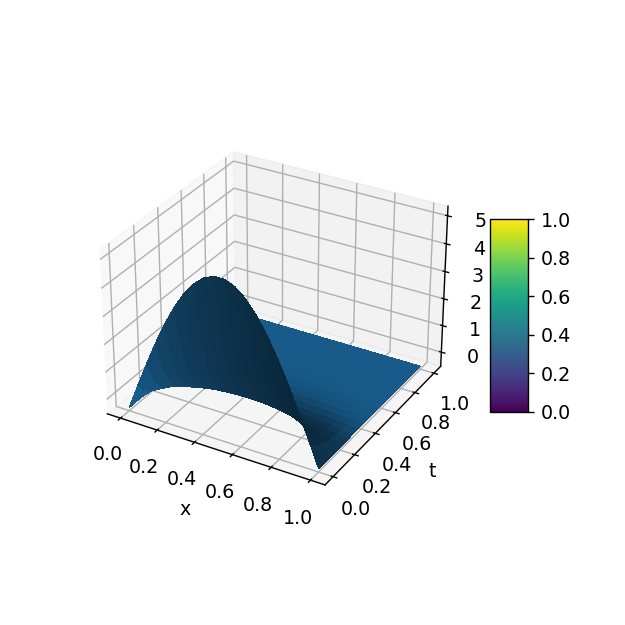

In [9]:
# Plot original data
plot_data.make_3D_surface_plot(x=grid_x1, y=grid_x2, z=data.reshape(np.shape(grid_x1)[0], np.shape(grid_x1)[1]))

<IPython.core.display.Javascript object>


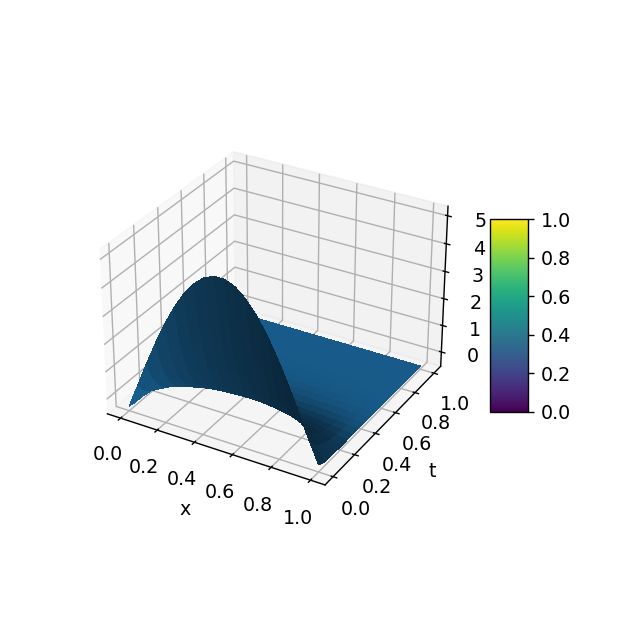

In [10]:
# Plot fitted data
plot_data.make_3D_surface_plot(x=grid_x1, y=grid_x2, z=mean_prediction.reshape(np.shape(grid_x1)[0], np.shape(grid_x1)[1]))

<IPython.core.display.Javascript object>


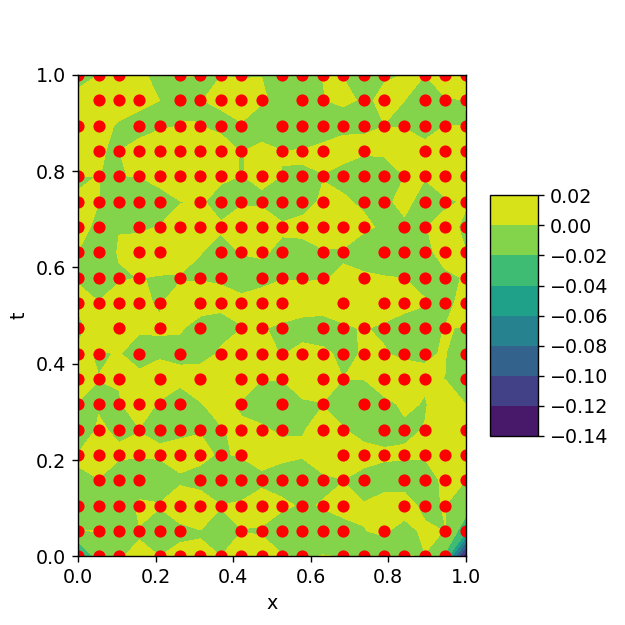

In [11]:
error = data.reshape(np.shape(grid_x1)[0], np.shape(grid_x1)[1]) - mean_prediction.reshape(np.shape(grid_x1)[0], np.shape(grid_x1)[1])
# Plot error
plot_data.make_3D_contour_plot(x=grid_x1, y=grid_x2, z=error, add_train=True, x_train=grid_train[:,0], y_train=grid_train[:,1])

<IPython.core.display.Javascript object>


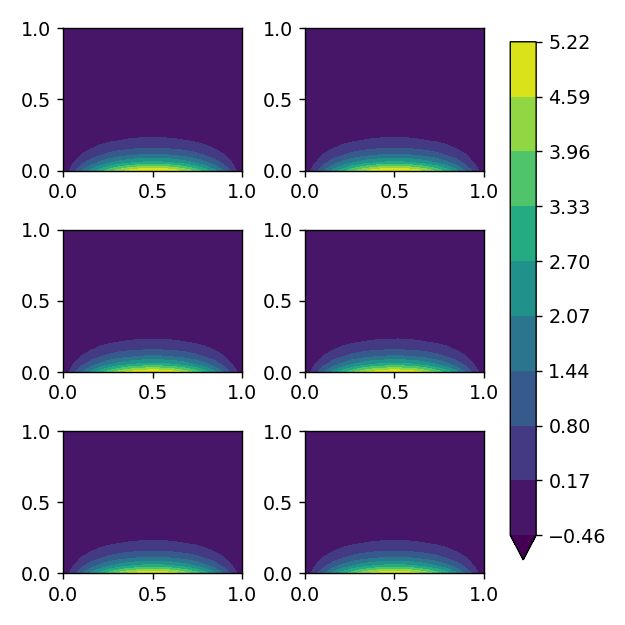

In [12]:
# Plot posteriors
posteriors = plot_data.plot_posteriors(x=grid_x1, y=grid_x2, z=data.reshape(np.shape(grid_x1)[0], np.shape(grid_x1)[1]), mean_pred=mean_prediction.flatten(),
                                               cov_pred=cov_prediction,
                                               posterior_nums=5, add_train_ind=False, x_train_val=grid_train)

## Fit specific model